In [10]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [11]:
full_df = pd.read_csv("../data/processed/full_df.csv")
full_df['tokens'] = full_df['tokens'].apply(ast.literal_eval)
full_df['tokens_str'] = full_df['tokens'].apply(lambda x:" ".join(x))
#subject_start = full_df['cleaned_body'].str.startswith('subject')

#full_df.loc[subject_start, 'cleaned_body'] = full_df.loc[subject_start, 'cleaned_body'].apply(
#    lambda x: x[len('subject'):].lstrip()
#)
# Display them
#print(full_df['cleaned_body'].str.startswith('subject').sum()) 

In [12]:
bow_vectorizer = CountVectorizer(stop_words='english', max_features= 10000, min_df=4, ngram_range =(1,3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_bow = bow_vectorizer.fit_transform(full_df['tokens_str'])
print(X_bow.shape)
bow_features = bow_vectorizer.get_feature_names_out()


(125922, 10000)


In [13]:
bow_counts = np.asarray(X_bow.sum(axis=0)).flatten()
bow_freq = pd.Series(bow_counts, index=bow_features).sort_values(ascending=False)
print(bow_freq.head(20))


email          63451
enron          62770
new            56916
time           50862
list           48619
company        47864
ect            44971
message        42626
like           42095
use            40829
need           38111
price          37838
information    37773
work           36366
make           35319
know           34794
day            33680
business       31777
file           31551
year           31017
dtype: int64


In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,min_df=4,ngram_range=(1, 3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_tfidf = tfidf_vectorizer.fit_transform(full_df['tokens_str'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).flatten()

tfidf_scores = pd.Series(tfidf_sum, index = tfidf_features).sort_values(ascending=False)

print(tfidf_scores.head(20))
tfidf_scores.sample(30)

email      2172.637526
list       1804.322873
new        1591.142681
like       1576.940988
time       1568.432397
price      1547.556516
enron      1532.483283
watch      1506.452133
message    1475.704425
wrote      1468.561760
need       1409.463282
use        1401.073259
know       1390.358673
work       1327.433919
day        1322.962672
ect        1307.652027
com        1297.313740
file       1294.857861
thanks     1284.358226
mailing    1277.319169
dtype: float64


financial                   281.126938
firewall                     45.425903
transform                    24.348429
retail price intuit          11.490752
hottest                     215.524642
par                          58.030220
compensated                  24.096861
blair                        31.596688
land                        135.120514
selection product            56.714453
fresh news                   60.185651
oxford fax                   31.933251
anybody                     136.816500
adobe desk reference         17.262274
right reserved received      12.842268
sids                         11.302570
email option unsubscribe     26.363620
directly manufacturer        19.236665
raise                       109.761630
mission provide secure       32.186288
apologize                    68.957187
gas price                    21.780281
cooking                      19.118167
annuity                      26.801580
disclaimer                   57.979549
warehouse                

In [15]:
combined_features = pd.concat([bow_freq, tfidf_scores], axis = 1)

combined_features.columns = ['BoW Frequency', 'TF-IDF Score']

combined_features = combined_features.sort_values(by='BoW Frequency', ascending=False)
combined_features.to_csv('../data/processed/combined_features_bow_tfidf.csv')
print(combined_features.head(20))



             BoW Frequency  TF-IDF Score
email                63451   2172.637526
enron                62770   1532.483283
new                  56916   1591.142681
time                 50862   1568.432397
list                 48619   1804.322873
company              47864   1087.791578
ect                  44971   1307.652027
message              42626   1475.704425
like                 42095   1576.940988
use                  40829   1401.073259
need                 38111   1409.463282
price                37838   1547.556516
information          37773   1126.926693
work                 36366   1327.433919
make                 35319   1227.861435
know                 34794   1390.358673
day                  33680   1322.962672
business             31777    920.433783
file                 31551   1294.857861
year                 31017    911.231121


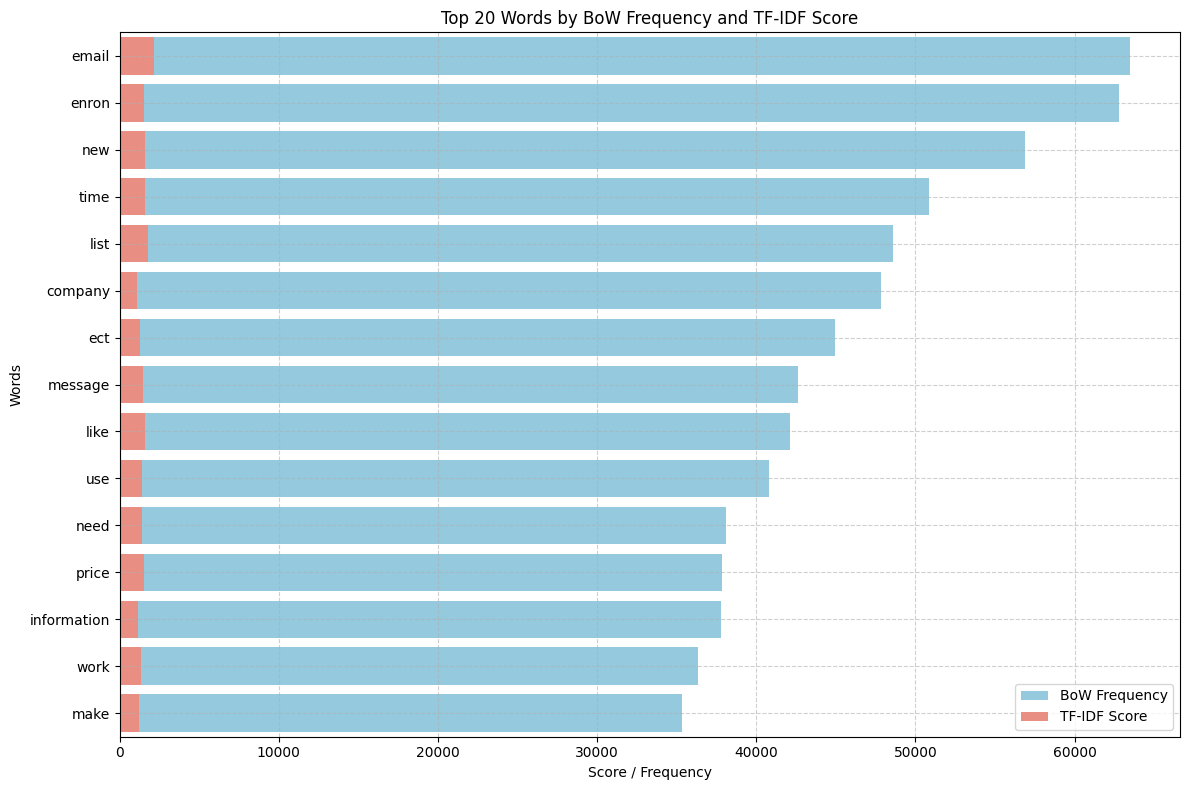

In [16]:
top_n = 15  
top_words = combined_features.head(top_n)

plt.figure(figsize=(12, 8))

sns.barplot(
    x=top_words['BoW Frequency'],
    y=top_words.index,
    color='skyblue',
    label='BoW Frequency'
)

sns.barplot(
    x=top_words['TF-IDF Score'],
    y=top_words.index,
    color='salmon',
    label='TF-IDF Score'
)

plt.title('Top 20 Words by BoW Frequency and TF-IDF Score')
plt.xlabel('Score / Frequency')
plt.ylabel('Words')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

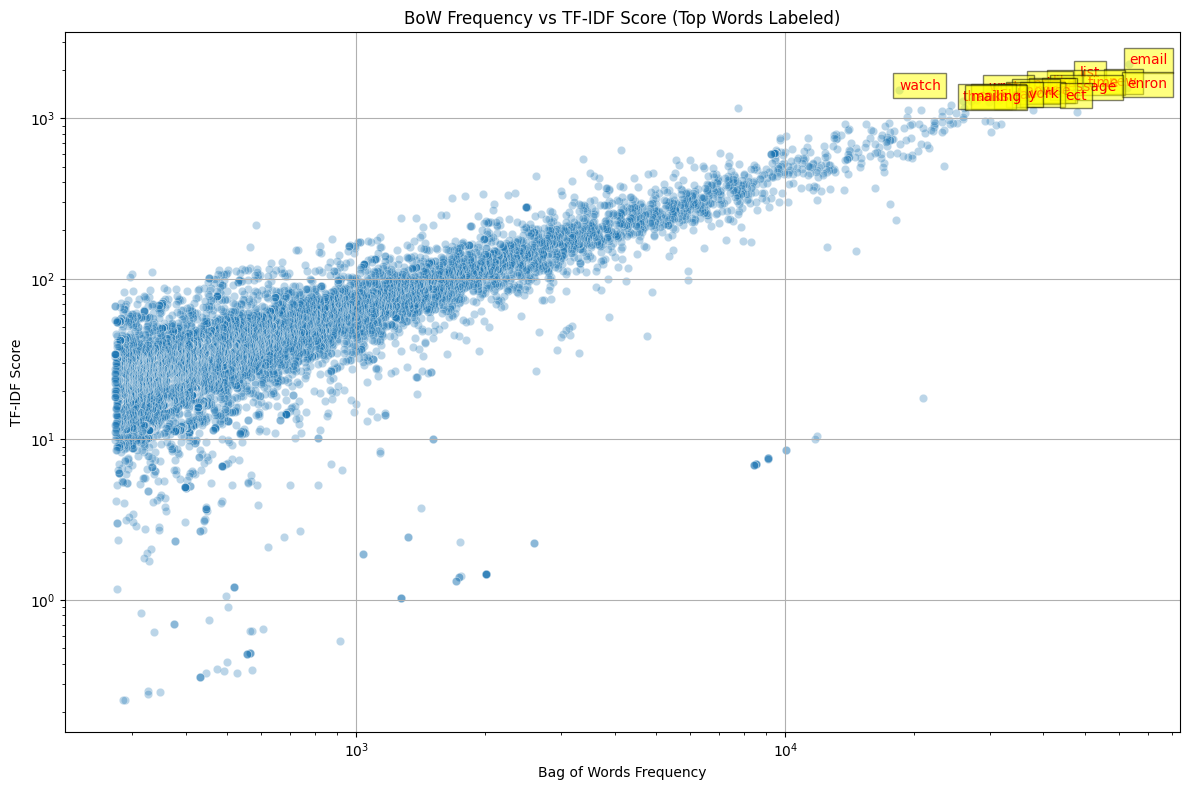

In [17]:
top_words = combined_features.sort_values(by='TF-IDF Score', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_features,
    x='BoW Frequency',
    y='TF-IDF Score',
    alpha=0.3
)

for i in range(top_words.shape[0]):
    plt.text(
        x=top_words['BoW Frequency'].iloc[i],
        y=top_words['TF-IDF Score'].iloc[i],
        s=top_words.index[i],
        fontdict=dict(color='red', size=10),
        bbox=dict(facecolor='yellow', alpha=0.5)
    )

plt.title('BoW Frequency vs TF-IDF Score (Top Words Labeled)')
plt.xlabel('Bag of Words Frequency')
plt.ylabel('TF-IDF Score')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
label = full_df['label']
data = {'X_bow': X_bow, 'X_tfidf': X_tfidf, 'label': label, 'bow_vectorizer': bow_vectorizer, 'tfidf_vectorizer': tfidf_vectorizer}

with open('../Models/engineered_features_bow_tfidf.pkl', 'wb') as f:
    pickle.dump(data,f)